In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json(open("result.json"))

df = pd.DataFrame(df[df.function.isin(['merge-100000', 'pandas_groupby-2880-1s-16H', 'merge_slow-20000-0.1'])])


def fix(name):
    name = name.replace("dask-1n", "dask-ws-1n")
    name = name.replace("dask-7n", "dask-ws-7n")
    return name
df["cluster"] = df.cluster.apply(fix)

def extract_nodes(data):
    name = data.cluster.split("-")
    return int(name[3][:-1])

df["scheduler"] = df.cluster.apply(lambda x: x.split("-")[1])
df["nodes"] = df.apply(extract_nodes, axis=1)
df["workers"] = df["nodes"] * 24
df["runtime"] = df.cluster.apply(lambda x: x.split("-")[0])

In [9]:
df.nodes.unique()

array([ 7,  9, 11, 13, 15, 23, 31])

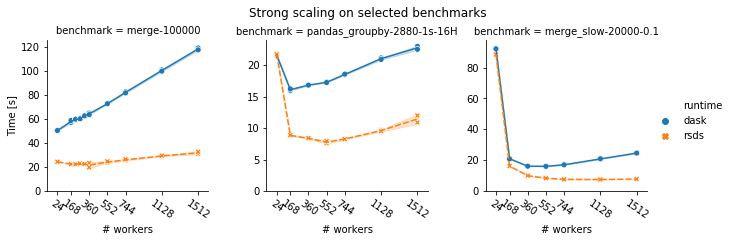

In [9]:
df["benchmark"] = df["function"]

def plot(data, **kw):
    sns.lineplot(data=data, x="workers", y="time", ci="sd", hue="runtime", style="runtime")
    sns.scatterplot(data=data, x="workers", y="time", hue="runtime", style="runtime")
    plt.xticks(sorted(data.workers.unique()))        

#gdata = df.groupby(["function", "runtime", "scheduler", "nodes"])["time"].mean()
#gdata
#plt.title()

data = df[df.scheduler == "ws"]  # sanity check
g = sns.FacetGrid(df, col="benchmark", col_wrap=3, sharey=False, sharex=True)
g = g.map_dataframe(plot)
g.add_legend()
g.set_ylabels("Time [s]")
g.set_xlabels("# workers")
g.set(ylim=(0, None))
plt.subplots_adjust(top=0.83)
g.fig.suptitle('Strong scaling on selected benchmarks')
#plt.xscale("log")
g.set_xticklabels(rotation=-35)

plt.savefig("scaling.png", tight_layout=True)



[6, 'dask', 'ws', '6n', '24p', '1t']
[5, 'rsds', 'ws', '5n', '24p', '1t']
[7, 'rsds', 'ws', '7n', '24p', '1t']
[1, 'dask', 'ws', '1n', '24p', '1t']
[2, 'rsds', 'ws', '2n', '24p', '1t']
[7, 'dask', 'ws', '7n', '24p', '1t']
[6, 'rsds', 'ws', '6n', '24p', '1t']
[3, 'rsds', 'ws', '3n', '24p', '1t']
[3, 'dask', 'ws', '3n', '24p', '1t']
[2, 'dask', 'ws', '2n', '24p', '1t']
[4, 'rsds', 'ws', '4n', '24p', '1t']
[1, 'rsds', 'ws', '1n', '24p', '1t']
[5, 'dask', 'ws', '5n', '24p', '1t']
[4, 'dask', 'ws', '4n', '24p', '1t']


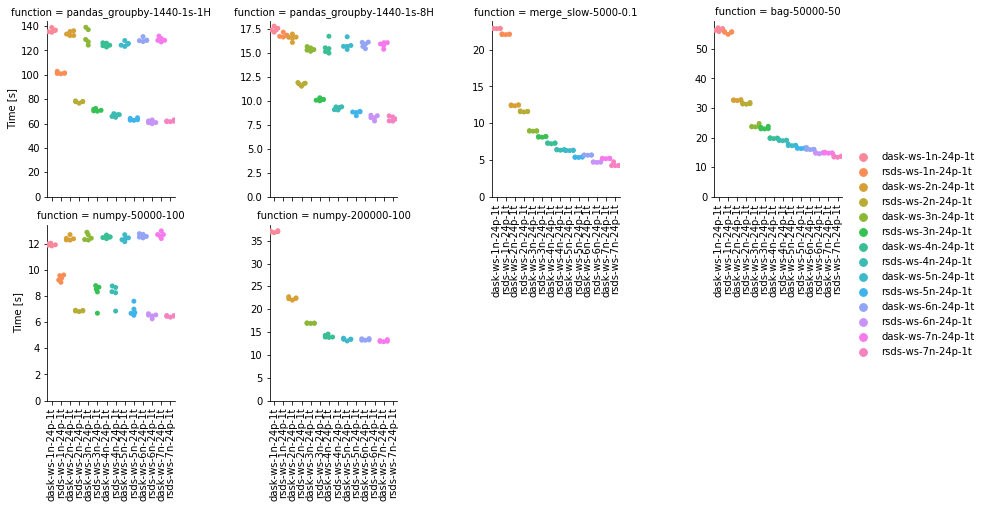

In [43]:
def create_plot(frame, plot_fn):
    def extract(fn):
        sortkey = []
        for item in fn.split("-"):
            try:
                num = float(item)
                sortkey.append(num)
            except:
                pass
        return tuple(sortkey)
    
    
    def cluster_key(name):        
        t = name.split("-")
        for x in t:
            if x and x[0].isdigit():
                break        
        key = [int(x[:-1])] + t
        print(key)
        return key
    
    clusters = sorted(set(frame["cluster"]), key=cluster_key)
    functions = sorted(frame["function"].unique(), key=extract)

    def plot(data, **kwargs):
        plot_fn(data, clusters, **kwargs)

    g = sns.FacetGrid(frame, col="function", col_wrap=4, col_order=functions, sharey=False)
    g = g.map_dataframe(plot)
    g = g.add_legend()
    g.set_ylabels("Time [s]")
    g.set(ylim=(0, None))
    g.set_xticklabels(rotation=90)
    return g

def plot_scatter(data, clusters, **kwargs):
    y = data["time"]
    sns.swarmplot(x=data["cluster"], y=y, hue=data["cluster"], order=clusters, hue_order=clusters)


#selection = df[df.function.isin(["xarray-5", "tree-15", "pandas_groupby-90-1s-8H", "numpy-50000-10"])]
selection = df
create_plot(selection, plot_scatter)
#plt.savefig('ws_sample.png', bbox_inches='tight')